2000-01-01      2.84
2000-02-01      5.34
2000-03-01      6.88
2000-04-01     13.64
2000-05-01     16.50
               ...  
2025-08-01   -999.00
2025-09-01   -999.00
2025-10-01   -999.00
2025-11-01   -999.00
2025-12-01   -999.00
Length: 312, dtype: float64


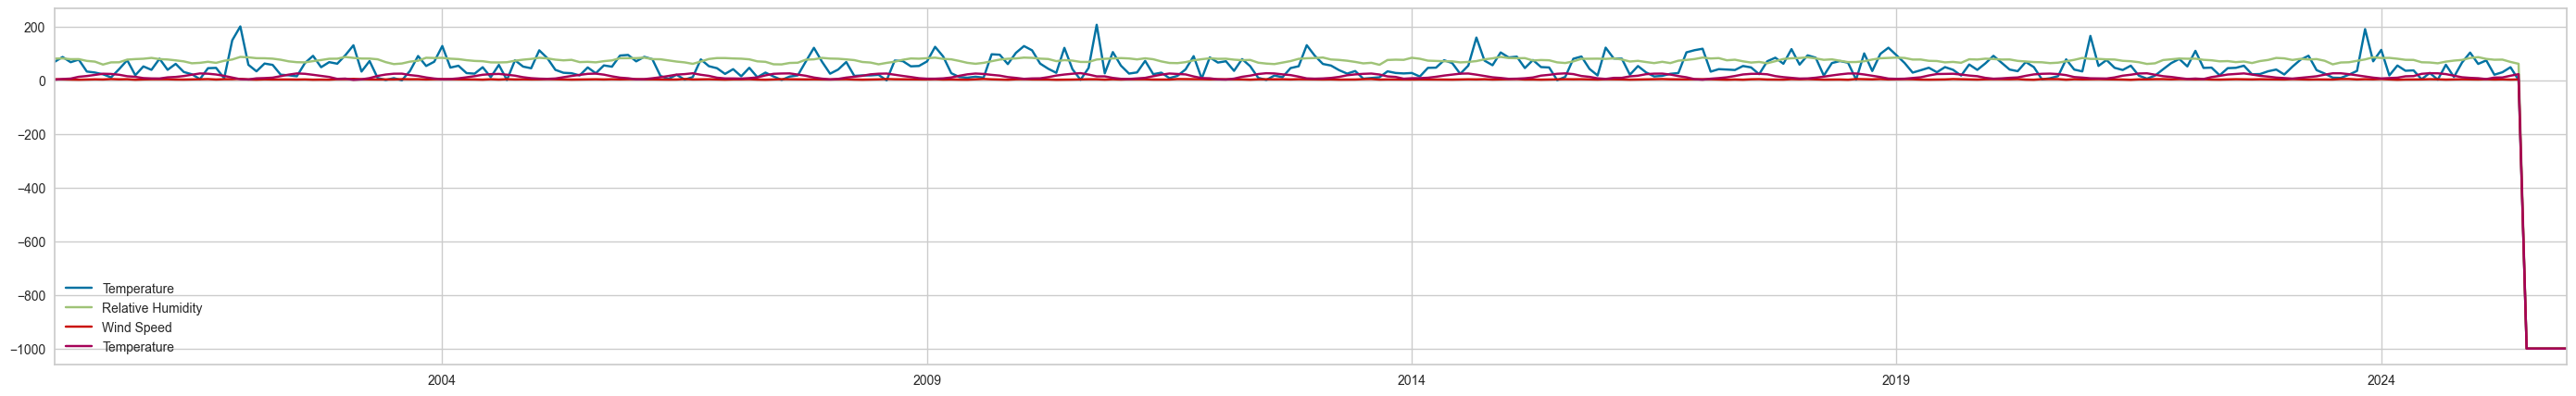

In [1]:
import pandas as pd
from pycaret.regression import *
from pycaret.time_series import *
from pycaret.datasets import get_data
import requests

#download data

response = requests.get("https://power.larc.nasa.gov/api/temporal/monthly/point?parameters=T2M,PRECTOTCORR_SUM,RH2M,WS2M&community=SB&longitude=29.02&latitude=41.10&format=JSON&start=2000&end=2025") 

data_bundle = response.json()

#independent variables

precipitaiton_data = data_bundle['properties']['parameter']['PRECTOTCORR_SUM']

relative_humidity_data = data_bundle['properties']['parameter']['RH2M']

wind_speed_data = data_bundle['properties']['parameter']['WS2M']


#dependent variable

tempereture_data = data_bundle['properties']['parameter']['T2M']

#print(data_bundle)

#drop the sum of every year's value

prep_filtered_data = {k: v for i, (k, v) in enumerate(precipitaiton_data.items()) if (i + 1) % 13 != 0}
rel_hum_filtered_data = {k: v for i, (k, v) in enumerate(relative_humidity_data.items()) if (i + 1) % 13 != 0}
wind_speed_filtered_data = {k: v for i, (k, v) in enumerate(wind_speed_data.items()) if (i + 1) % 13 != 0}
temp_filtered_data = {k: v for i, (k, v) in enumerate(tempereture_data.items()) if (i + 1) % 13 != 0}

# Convert to time series format
precipitation_series = pd.Series(prep_filtered_data)
precipitation_series.index = pd.to_datetime(precipitation_series.index, format='%Y%m')
precipitation_series = precipitation_series.sort_index()
#print(precipitation_series)     
relative_humidity_series = pd.Series(rel_hum_filtered_data)
relative_humidity_series.index = pd.to_datetime(relative_humidity_series.index, format='%Y%m')
relative_humidity_series = relative_humidity_series.sort_index()
#print(relative_humidity_series)
wind_speed_series = pd.Series(wind_speed_filtered_data)
wind_speed_series.index = pd.to_datetime(wind_speed_series.index, format='%Y%m')
wind_speed_series = wind_speed_series.sort_index()
#print(wind_speed_series)
temp_series = pd.Series(temp_filtered_data)
temp_series.index = pd.to_datetime(temp_series.index, format='%Y%m')
temp_series = temp_series.sort_index()

#visualize data

precipitation_series.plot(figsize =(35,5),legend=True,label='Temperature')
relative_humidity_series.plot(figsize =(35,5),legend=True,label='Relative Humidity')
wind_speed_series.plot(figsize =(35,5),legend=True,label='Wind Speed')
temp_series.plot(figsize =(35,5),legend=True,label='Temperature')
print(temp_series)

2000-01-01     2.84
2000-02-01     5.34
2000-03-01     6.88
2000-04-01    13.64
2000-05-01    16.50
              ...  
2025-02-01     5.12
2025-03-01    10.71
2025-04-01    11.13
2025-05-01    17.61
2025-06-01    23.36
Length: 306, dtype: float64


<Axes: >

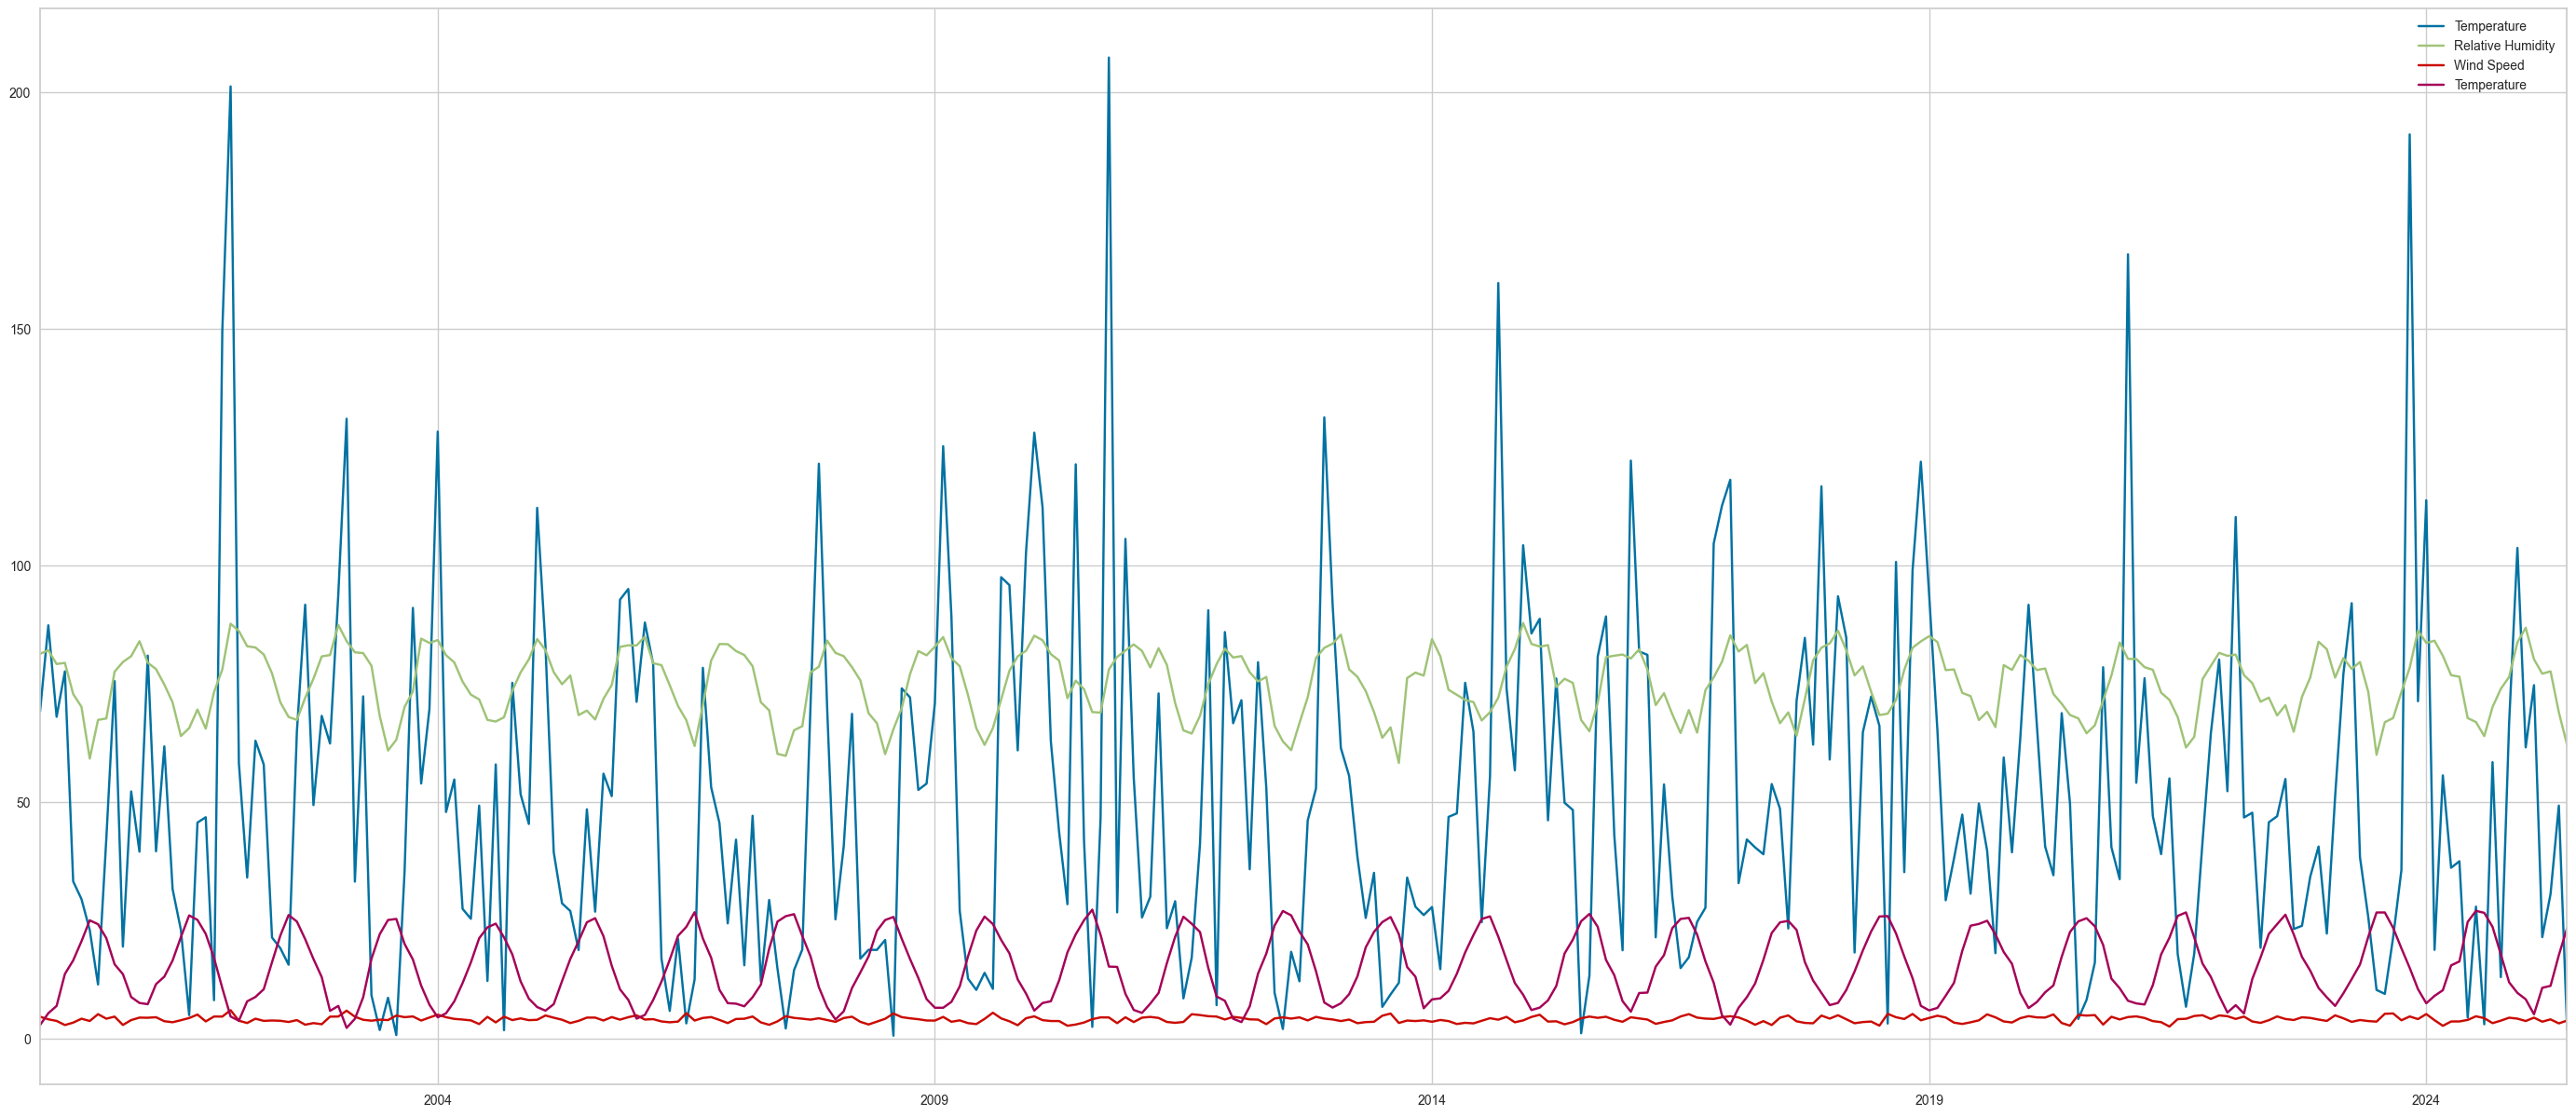

In [2]:
# remove rows with -999 in the last 6 months appearing the plot above

precipitation_series = precipitation_series[precipitation_series.index < pd.to_datetime('2025-07')]
relative_humidity_series = relative_humidity_series[relative_humidity_series.index < pd.to_datetime('2025-07')]
wind_speed_series = wind_speed_series[wind_speed_series.index < pd.to_datetime('2025-07')]
temp_series = temp_series[temp_series.index < pd.to_datetime('2025-07')]

# after removing printing and visualizing the data again

print(temp_series)
precipitation_series.plot(figsize =(35,15),legend=True,label='Temperature')
relative_humidity_series.plot(figsize =(35,15),legend=True,label='Relative Humidity')
wind_speed_series.plot(figsize =(35,15),legend=True,label='Wind Speed')
temp_series.plot(figsize =(35,15),legend=True,label='Temperature')


In [3]:
# null value check 

prep_df = pd.DataFrame(precipitation_series.values, columns=['Precipitation'])

rel_hun_df = pd.DataFrame(relative_humidity_series.values, columns=['Relative Humidity'])
wind_speed_df = pd.DataFrame(wind_speed_series.values, columns=['Wind Speed'])    
temp_df = pd.DataFrame(temp_series.values, columns=['Temperature'])
dataset = pd.concat([prep_df, rel_hun_df, wind_speed_df, temp_df], axis=1)


nul_data = pd.isnull(dataset['Precipitation']) & pd.isnull(dataset['Relative Humidity']) & pd.isnull(dataset['Wind Speed']) & pd.isnull(dataset['Temperature'])
    
# print only the null data- no nul values in the dataset
dataset[nul_data]


,Precipitation,Relative Humidity,Wind Speed,Temperature


In [4]:
# setup the experiment

exp = TSForecastingExperiment()

# forecast horizon is 36 months, 5 fold is selected for cross-validation

exp.setup(temp_series, fh=36,fold=5,session_id=123)

# automatically seasonality is detected.

,Description,Value
0,session_id,123
1,Target,Time Series
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(306, 1)"
5,Transformed data shape,"(306, 1)"
6,Transformed train set shape,"(270, 1)"
7,Transformed test set shape,"(36, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


In [5]:
# exploring some basic statistics

exp.check_stats()

,Test,Test Name,Data,Property,Setting,Value
0,Summary,Statistics,Transformed,Length,,306.0
1,Summary,Statistics,Transformed,# Missing Values,,0.0
2,Summary,Statistics,Transformed,Mean,,15.223922
3,Summary,Statistics,Transformed,Median,,15.16
4,Summary,Statistics,Transformed,Standard Deviation,,7.096166
5,Summary,Statistics,Transformed,Variance,,50.355566
6,Summary,Statistics,Transformed,Kurtosis,,-1.354062
7,Summary,Statistics,Transformed,Skewness,,0.09463
8,Summary,Statistics,Transformed,# Distinct Values,,288.0
9,White Noise,Ljung-Box,Transformed,Test Statictic,"{'alpha': 0.05, 'K': 24}",3265.161886


In [6]:
# train-test split can be done accoriding to forecast horizon (36 months)
exp.plot_model(plot='train_test_split')

In [7]:
# cross-validation is to avoid overfitting.
exp.plot_model(plot='cv')

In [8]:
# upto 12 lags are shown in the plot below. The first 12 lags are significant.
exp.plot_model(plot='pacf')

In [9]:
# timeseries is decomposed into seasonal , trend and random components. As shown in the orange there is a strong seasinoality.
#  And a slight upward trend.
exp.plot_model(plot='decomp_stl')

In [10]:
best = exp.compare_models(sort='R2', turbo=False)

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
en_cds_dt,Elastic Net w/ Cond. Deseasonalize & Detrending,0.6889,0.6678,1.0191,1.2846,0.0989,0.0918,0.9664,0.4560
lasso_cds_dt,Lasso w/ Cond. Deseasonalize & Detrending,0.6896,0.6681,1.0201,1.2853,0.0990,0.0918,0.9664,0.3680
llar_cds_dt,Lasso Least Angular Regressor w/ Cond. Deseasonalize & Detrending,0.6896,0.6681,1.0201,1.2853,0.0990,0.0918,0.9664,0.3320
omp_cds_dt,Orthogonal Matching Pursuit w/ Cond. Deseasonalize & Detrending,0.6873,0.6678,1.0168,1.2846,0.0988,0.0917,0.9663,0.3440
br_cds_dt,Bayesian Ridge w/ Cond. Deseasonalize & Detrending,0.6884,0.6729,1.0185,1.2945,0.0992,0.0919,0.9659,0.3700
huber_cds_dt,Huber w/ Cond. Deseasonalize & Detrending,0.6884,0.6785,1.0184,1.3052,0.0988,0.0921,0.9653,0.3520
rf_cds_dt,Random Forest w/ Cond. Deseasonalize & Detrending,0.6882,0.6831,1.0179,1.3144,0.0983,0.0930,0.9650,0.7160
tbats,TBATS,0.7156,0.6838,1.0591,1.3162,0.1017,0.0956,0.9648,16.8200
lr_cds_dt,Linear w/ Cond. Deseasonalize & Detrending,0.7068,0.6875,1.0459,1.3230,0.1016,0.0942,0.9646,0.4720
ridge_cds_dt,Ridge w/ Cond. Deseasonalize & Detrending,0.7061,0.6871,1.0449,1.3221,0.1015,0.0941,0.9646,0.3420


In [12]:
selected_model = exp.create_model('en_cds_dt')

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2007-06,0.5421,0.5149,0.8117,1.0075,0.0746,0.0752,0.9796
1,2010-06,0.9241,0.8670,1.2910,1.5758,0.1295,0.1162,0.9558
2,2013-06,0.6562,0.6296,1.0016,1.2535,0.0844,0.0870,0.9655
3,2016-06,0.5945,0.6088,0.8959,1.1903,0.1103,0.0900,0.9725
4,2019-06,0.7277,0.7188,1.0952,1.3960,0.0960,0.0904,0.9585
Mean,NaT,0.6889,0.6678,1.0191,1.2846,0.0989,0.0918,0.9664
SD,NaT,0.1329,0.1188,0.1663,0.1918,0.0194,0.0134,0.0088


In [16]:
exp.plot_model(selected_model, plot='forecast')

In [18]:
final = exp.finalize_model(selected_model)

In [20]:
exp.plot_model(final, plot='forecast', data_kwargs= {'fh':36})

In [21]:
pred = exp.predict_model(final, fh=36)
pred

,y_pred
2025-07,26.0813
2025-08,26.4220
2025-09,22.8103
2025-10,17.8203
2025-11,13.3646
2025-12,9.0363
2026-01,6.9492
2026-02,7.5154
2026-03,9.3672
2026-04,13.1028


<Axes: >

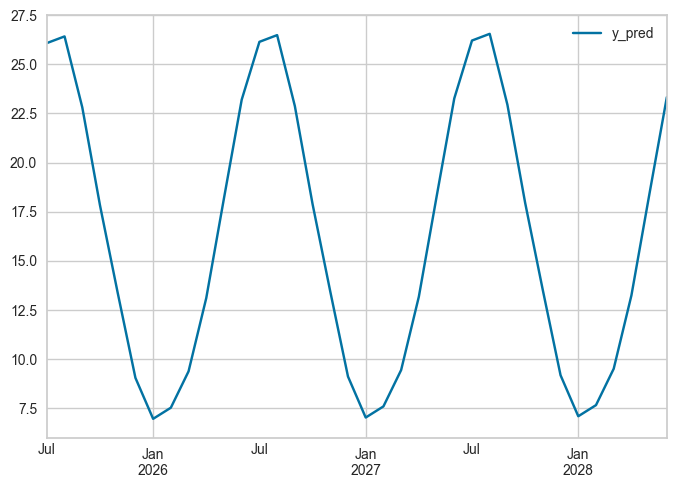

In [22]:
pred.plot()